In [1]:
import os, sys, time, resource, re, gc, shutil
from multiprocess import Pool
from functools import partial
from urllib.parse import urlparse, parse_qsl

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mongoengine.queryset.visitor import Q
import django
from django.db.models import *
sys.path.append('/home/galm/software/django/tmv/BasicBrowser/')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

from scoping.models import *
from tmv_app.models import *
from utils.text import *
from sklearn.feature_extraction.text import *
from sklearn.decomposition import NMF

from run_id import run_id
run_id=1103
stat = RunStats.objects.get(pk=run_id)
q = stat.query
print(q.title)



wos_updated_2018


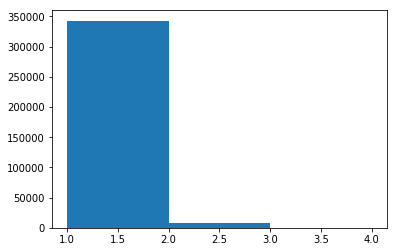

In [2]:
ds = Doc.objects.filter(query=q).values('id').annotate(
    n = Count('wc__oecd',distinct=True)
)
ds.order_by('-n')

plt.hist([x['n'] for x in ds],bins=[1, 2, 3, 4])

plt.savefig('../plots/multi_discipline_docs.png')

In [3]:
docs = Doc.objects.filter(query=q,PY__lt=2019)

js = docs.filter(journal__isnull=False).values('journal__id','journal__fulltext','journal__abbrev').annotate(
    n = Count('id')
)
top_js = js.order_by('-n')[:10]

In [4]:
jys = docs.filter(journal__in=top_js.values_list('journal_id',flat=True)).values('PY','journal__fulltext','journal__abbrev').annotate(
    n = Count('id')
)
df = pd.DataFrame.from_dict(list(jys))
df.head()

,PY,journal__abbrev,journal__fulltext,n
0,1976,GEOPHYS RES LETT,GEOPHYSICAL RESEARCH LETTERS,3
1,1977,CLIMATIC CHANGE,CLIMATIC CHANGE,11
2,1977,GEOPHYS RES LETT,GEOPHYSICAL RESEARCH LETTERS,2
3,1978,CLIMATIC CHANGE,CLIMATIC CHANGE,18
4,1978,ENERG POLICY,ENERGY POLICY,1


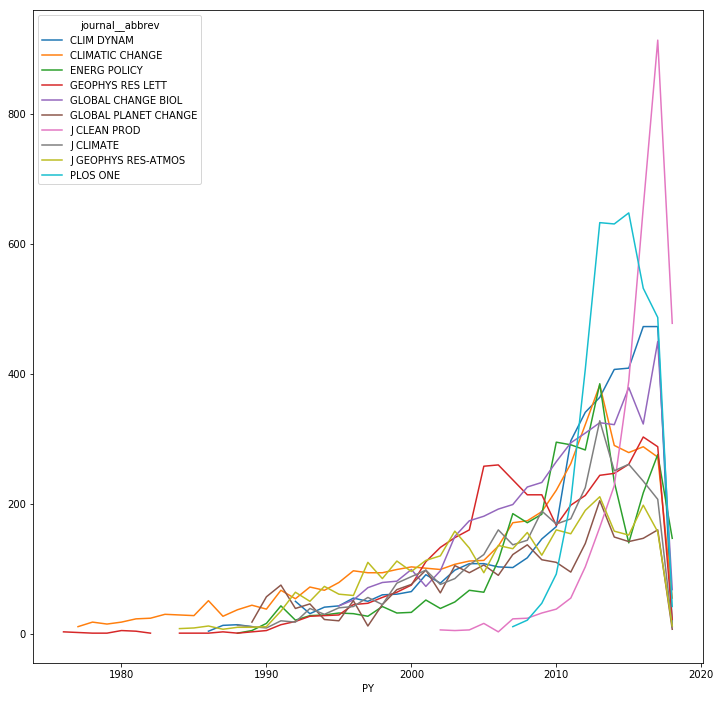

In [5]:
plt.rcParams["figure.figsize"] = [12,12]

pdf = df.pivot('PY','journal__abbrev','n')
pdf.head()

pdf.plot()
plt.savefig('../plots/journals/journal_papers.png',bbox_inches='tight')        
plt.show()

In [6]:
cjys = docs.filter(journal__in=top_js.values_list('journal_id',flat=True)).values('PY','journal__fulltext','journal__abbrev').annotate(
    n = Sum('wosarticle__tc')
)
df = pd.DataFrame.from_dict(list(cjys))
df.head()

,PY,journal__abbrev,journal__fulltext,n
0,1976,GEOPHYS RES LETT,GEOPHYSICAL RESEARCH LETTERS,229
1,1977,CLIMATIC CHANGE,CLIMATIC CHANGE,684
2,1977,GEOPHYS RES LETT,GEOPHYSICAL RESEARCH LETTERS,37
3,1978,CLIMATIC CHANGE,CLIMATIC CHANGE,131
4,1978,ENERG POLICY,ENERGY POLICY,4


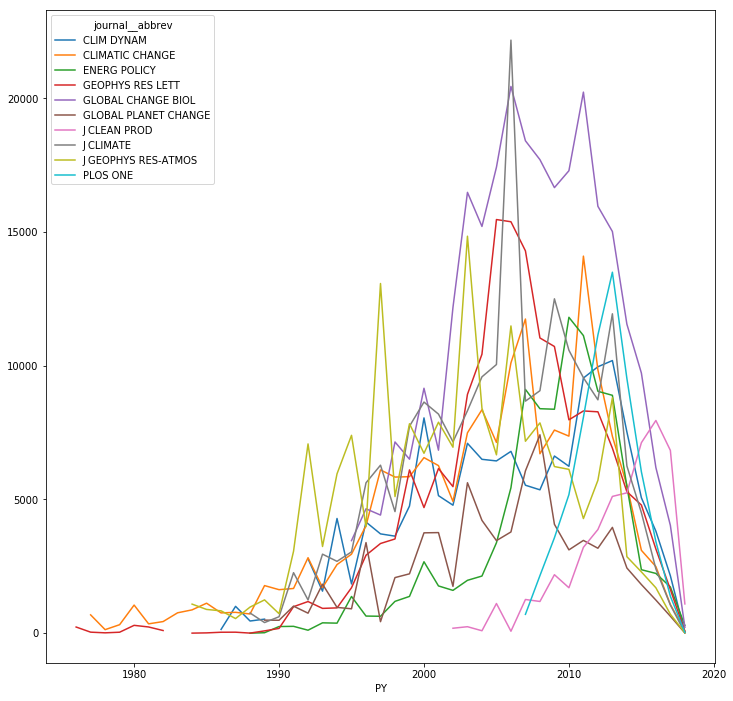

In [7]:
plt.rcParams["figure.figsize"] = [12,12]

pdf = df.pivot('PY','journal__abbrev','n')
pdf.head()

pdf.plot()

plt.show()

In [8]:
njournals = JournalAbbrev.objects.filter(doc__query=q).values('doc__PY').annotate(
    n = Count('id')
).order_by('doc__PY')
jdf = pd.DataFrame.from_dict(list(njournals))
#jdf = jdf.set_index('doc__PY')
jdf.head()

,doc__PY,n
0,1900.0,1
1,1903.0,1
2,1907.0,1
3,1910.0,2
4,1913.0,1


315239


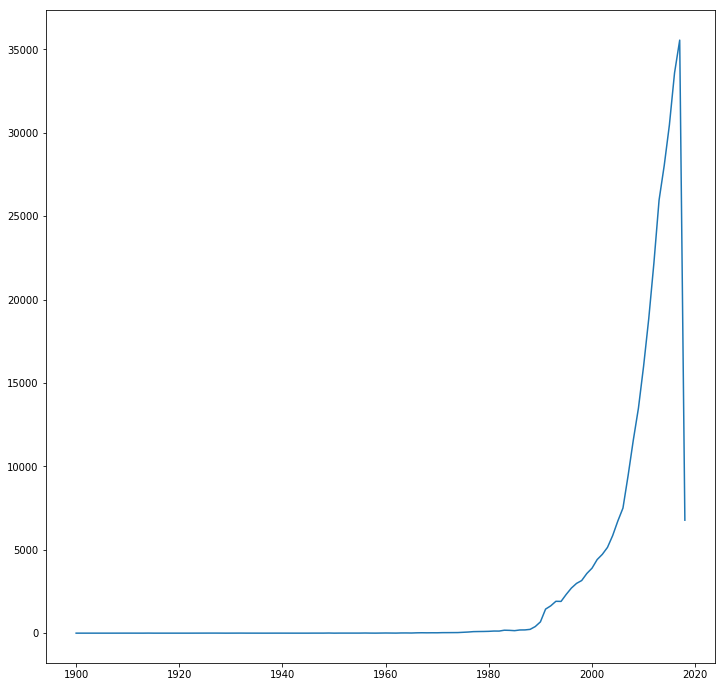

,doc__PY,n
0,1900.0,1
1,1903.0,1
2,1907.0,1
3,1910.0,2
4,1913.0,1


In [9]:
print(jdf['n'].sum())
plt.plot(jdf['doc__PY'],jdf['n'])
plt.savefig('../plots/journals/n_journals.png',bbox_inches='tight')        
plt.show()
jdf.head()

In [10]:
stat = RunStats.objects.get(pk=run_id)
print(stat.method)

if stat.method=="DT":
    DTO = DocDynamicTopic.objects
else:
    DTO = DocTopic.objects

for j in top_js:
    print(j['journal__fulltext'])
    print(j['n'])
    dts = DTO.filter(
        run_id=run_id,
        doc__journal__id=j['journal__id'],
        score__gt=stat.dt_threshold
    )
    tops = dts.values('topic').annotate(
        t = Sum('score')
    )
    print(tops.values('topic__title','t').order_by('-t')[:10])

DT
CLIMATIC CHANGE
4791
<QuerySet [{'topic__title': '{climate, future, global}', 't': 72.0385185935445}, {'topic__title': '{research, review, development}', 't': 53.839551445782}, {'topic__title': '{scenario, future, project}', 't': 49.6345097090512}, {'topic__title': '{uncertainty, estimate, projection}', 't': 36.97224443151}, {'topic__title': '{emission, greenhouse-gas, reduction}', 't': 33.8802618916357}, {'topic__title': '{crop, yield, wheat}', 't': 30.8901762882212}, {'topic__title': '{adaptation, local, mitigation}', 't': 30.4318219744678}, {'topic__title': '{temperature, air, mean}', 't': 28.7423632727132}, {'topic__title': '{year, period, annual}', 't': 28.5978839045856}, {'topic__title': '{model, simulation, simulate}', 't': 28.3253825870877}]>
GLOBAL CHANGE BIOLOGY
4685
<QuerySet [{'topic__title': '{leaf, photosynthetic, photosynthesis}', 't': 57.7979710244147}, {'topic__title': '{specie, distribution, range}', 't': 51.9927258534572}, {'topic__title': '{soil, content, microbi

In [11]:
HJs = js.order_by('-n')[:30]

for j in HJs:
    print(j['journal__fulltext'])
    dts = DTO.filter(
        run_id=run_id,
        doc__journal__id=j['journal__id'],
        score__gt=stat.dt_threshold
    )
    H = 0
    ts = dts.values('topic').annotate(
        pzc = Sum('score')
    )
    for t in ts:
        H+=t['pzc']*np.log(t['pzc'])
    H = -1*H
    j['H'] = H
    print(round(H))

CLIMATIC CHANGE
-3160.0
GLOBAL CHANGE BIOLOGY
-4259.0
CLIMATE DYNAMICS
-4456.0
GEOPHYSICAL RESEARCH LETTERS
-3249.0
PLOS ONE
-2603.0
ENERGY POLICY
-2757.0
JOURNAL OF CLIMATE
-3395.0
JOURNAL OF GEOPHYSICAL RESEARCH-ATMOSPHERES
-2619.0
JOURNAL OF CLEANER PRODUCTION
-2401.0
GLOBAL AND PLANETARY CHANGE
-1475.0
INTERNATIONAL JOURNAL OF GREENHOUSE GAS CONTROL
-1619.0
NATURE
-631.0
ENVIRONMENTAL SCIENCE & TECHNOLOGY
-987.0
RENEWABLE & SUSTAINABLE ENERGY REVIEWS
-1568.0
SCIENCE OF THE TOTAL ENVIRONMENT
-1288.0
PALAEOGEOGRAPHY PALAEOCLIMATOLOGY PALAEOECOLOGY
-1340.0
APPLIED ENERGY
-1523.0
ENERGY
-1460.0
QUATERNARY SCIENCE REVIEWS
-1673.0
PROCEEDINGS OF THE NATIONAL ACADEMY OF SCIENCES OF THE UNITED STATES OF AMERICA
-876.0
SCIENCE
-361.0
INTERNATIONAL JOURNAL OF CLIMATOLOGY
-1288.0
FOREST ECOLOGY AND MANAGEMENT
-1486.0
BIOGEOSCIENCES
-1263.0
SCIENTIFIC REPORTS
-810.0
ENVIRONMENTAL RESEARCH LETTERS
-1099.0
JOURNAL OF HYDROLOGY
-1144.0
QUATERNARY INTERNATIONAL
-848.0
SOIL BIOLOGY & BIOCHEMISTRY
-

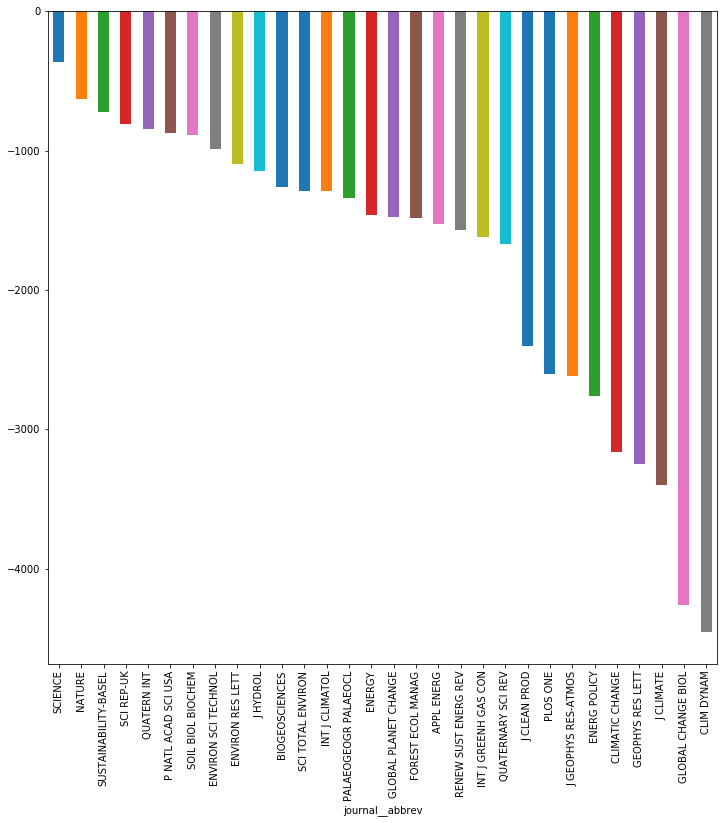

In [12]:
plt.rcParams["figure.figsize"] = [12,12]

df = pd.DataFrame.from_dict(list(HJs)).sort_values('H',ascending=False)

jorder = df['journal__abbrev']

df = df.set_index('journal__abbrev')

df.head()

df['H'].plot.bar()

plt.savefig('../plots/journals/journal_entropy_'+str(run_id)+'.png',bbox_inches='tight')        

plt.show()

In [13]:
pys = list(range(1990,2018))
from scipy.interpolate import make_interp_spline, BSpline


def get_entropy_time(pys,var,cats,run_id):
    Hs = []
    stat = RunStats.objects.get(pk=run_id)
    filters = {
        "run_id": run_id,
        "score__gt": stat.dt_threshold,
        f"{var}__isnull": False
    }

    for y in pys:
        filters['doc__PY'] = y
        for j in cats:
            filters[var] = j
            dts = DTO.filter(**filters)

            if dts.count()==0:
                continue

            H = 0
            ts = dts.values('topic').annotate(
                pzc = Sum('score')
            )

            for t in ts:
                H+=t['pzc']*np.log(t['pzc'])
            H = -1*H
            
            Hs.append({
                "cat": j,
                "H": H,
                "py": y,
            }) 
            
    df = pd.DataFrame.from_dict(Hs)
    return df

def plot_entropy_time(ax,df,cmap=None,smooth=False):
    lyear = df['py'].max()
    pdf = df[df['py']<=lyear]
    pdf['cat'] = pdf['cat'].astype("category")
    cats = list(pdf[pdf['py']==lyear].sort_values('H',ascending=False)['cat'])
    
    pdf['cat'].cat.set_categories(cats,inplace=True)
    pdf = pdf.sort_values('cat',ascending=True).reset_index(drop=True)

    for name, group in pdf.groupby('cat'):
        group = group.sort_values('py').reset_index(drop=True)
        
        x = group['py']
        y = group['H']
        
        if smooth: 
            xnew = np.linspace(x.min(),x.max(),smooth) #300 represents number of points to make between T.min and T.max
            spl = make_interp_spline(x, y, k=3) #BSpline object
            y = spl(xnew)
            x = xnew
        
        if cmap is not None:
            ax.plot(x,y,label=name,color=cmap[name])
        else:
            ax.plot(x,y,label=name)
        
    ax.legend()
    


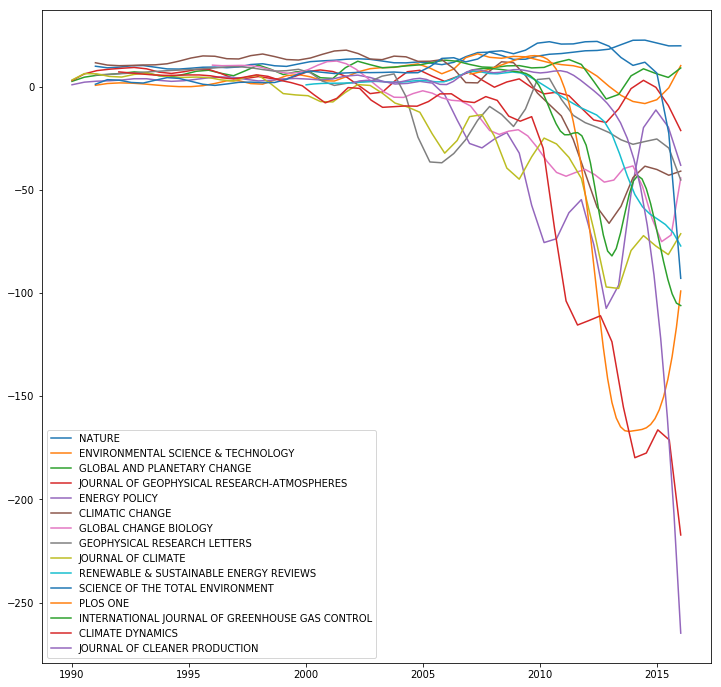

In [14]:
# Get entropy for each journal in each year
pys = list(range(1990,2017))
cats = [j['journal__fulltext'] for j in js.order_by('-n')[:15]]
jdf = get_entropy_time(pys,"doc__journal__fulltext", cats, run_id)


fig, ax = plt.subplots(figsize=(12,12))
plot_entropy_time(ax,jdf,smooth=50)
plt.savefig(f"../plots/journal_entropy_time_{run_id}")

In [15]:
pys = list(range(1990,2014))
wgs = [1,2,3]
wgdf = get_entropy_time(pys,'doc__ipccref__wg__wg',wgs, run_id)


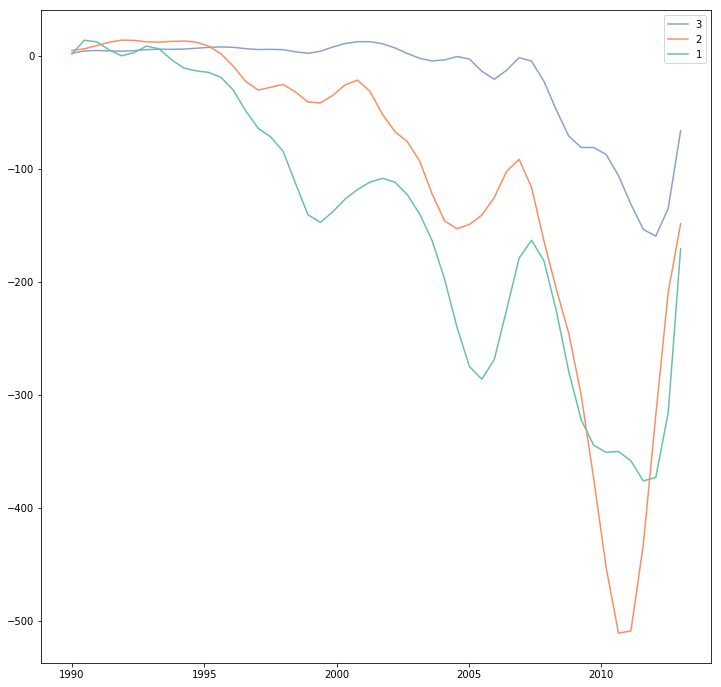

In [16]:
fig, ax = plt.subplots(figsize=(12,12))
cmap = {1: "#66c2a5", 2: "#fc8d62" , 3: "#8da0cb"}
plot_entropy_time(ax,wgdf,cmap, smooth=50)

plt.savefig(f"../plots/wg_entropy_time_{run_id}")

In [21]:
pys = list(range(1990,2014))
kws = Doc.objects.filter(query=q,kw__text__isnull=False).values('kw__text').annotate(
    n = Count('pk')
).order_by('-n')[:15].values_list('kw__text',flat=True)
kwdf = get_entropy_time(pys,'doc__kw__text',kws, run_id)


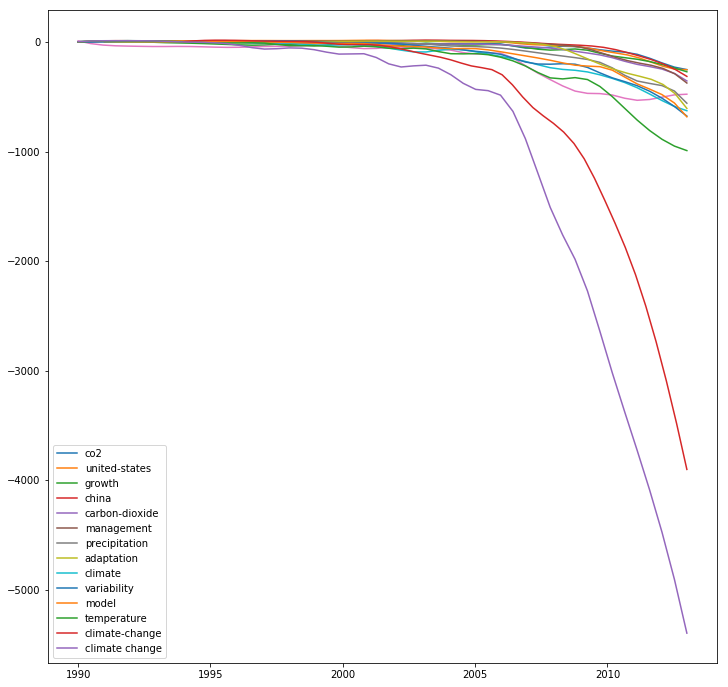

In [22]:

fig, ax = plt.subplots(figsize=(12,12))
plot_entropy_time(ax,kwdf, smooth=50)

plt.savefig(f"../plots/kw_entropy_time_{run_id}")

In [46]:
doc_ids = set(DTO.filter(
    run_id=run_id,
    score__gt=stat.dt_threshold
).values_list('doc_id',flat=True))



In [52]:
import random

Hs = []
pys = list(range(1990,2014))

for i in [1,2]:
    print(i)
    dids = random.sample(doc_ids,5000)
    dtos = DTO.filter(
        run_id=run_id,
        score__gt=stat.dt_threshold,
        doc__id__in=dids
    )
    for y in pys:
        dts = dtos.filter(doc__PY=y)
        if dts.count()==0:
            continue
            
        H = 0
        
        ts = dts.values('topic').annotate(
            pzc = Sum('score')
        )
        
        for t in ts:
            H+=t['pzc']*np.log(t['pzc'])
        H = -1*H

        Hs.append({
            "cat": i,
            "H": H,
            "py": y,
        }) 
        
rdf = pd.DataFrame.from_dict(Hs)
rdf.head()

1
2


,H,cat,py
0,0.990192,1,1990
1,6.089858,1,1991
2,7.307178,1,1992
3,8.140184,1,1993
4,9.230270,1,1994


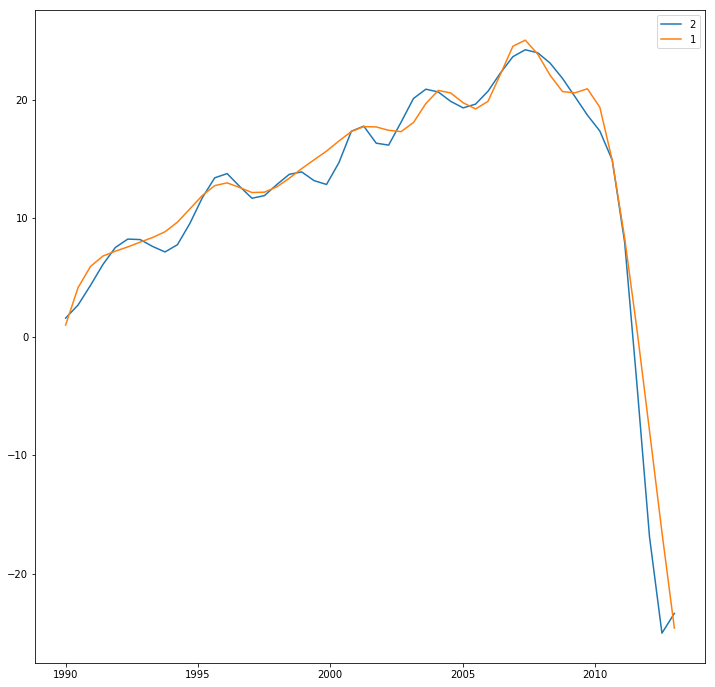

In [53]:
fig, ax = plt.subplots(figsize=(12,12))
plot_entropy_time(ax,rdf, smooth=50)

# Entropy
$$ H(z\rvert c,y) = -\sum_{i=1}^{K} \hat{p}(z_i \rvert c,y)  log \hat{p}(z_i \rvert c, y) $$

In [ ]:
dts = DocTopic.objects.filter(
    doc__journal__in=js.order_by('-n')[:30].values_list('journal__id'),
    run_id=run_id
)

dts = dts.values('doc__journal__abbrev','topic__title').annotate(
    s = Sum('score')
)
df = pd.DataFrame.from_dict(list(dts))

df.head()

In [ ]:
df['Journal'] = pd.Categorical(df['doc__journal__abbrev'],categories=jorder)
df['Topic'] = pd.Categorical(
    df['topic__title'],
    categories = list(Topic.objects.filter(
        run_id=run_id
    ).order_by('-score').values_list('title',flat=True)))
df = df.sort_values('Journal')
df.head()


In [ ]:
import seaborn as sns

pdf = df.pivot('Journal','Topic','s')

sns.set()

plt.rcParams["figure.figsize"] = [28,16]

sns.heatmap(pdf, linewidths=.5)

pdf.head()

plt.savefig('../plots/journals/journal_topics_'+str(run_id)+'.png',bbox_inches='tight')        

plt.show()

In [ ]:
dts = DocTopic.objects.filter(
    doc__journal__fulltext="NATURE"
)

dts.count()

In [ ]:
ytopics = []
y = 1990

stat = RunStats.objects.get(pk=run_id)
dt_threshold=stat.dthreshold

[0,1985,1990.1,1995.1,2001.1,2007.1,2013.1,9999]
ars = [
    {"name":"AR0","years":range(0,1985),"n":0},
    {"name":"AR1","years":range(1985,1991),"n":1},
    {"name":"AR2","years":range(1991,1995),"n":2},
    {"name":"AR3","years":range(1995,2001),"n":3},
    {"name":"AR4","years":range(2001,2008),"n":4},
    {"name":"AR5","years":range(2008,2014),"n":5},
    {"name":"AR6","years":range(2014,9999),"n":6}
]
for ar in ars:   
    ytopics = dts.filter(
        doc__PY__in=ar["years"],
        run_id=run_id,
        score__gt=dt_threshold
    ).values('topic_id').annotate(
        ttotal=models.Sum('score')
    ).values('topic_id','topic__title','ttotal')
    ndf =  pd.DataFrame.from_dict(list(ytopics))
    ndf['AP'] = ar["name"]
    ndf['APn'] = ar["n"]
    if ar["name"]=="AR0":
        df = ndf
    else:
        df = df.append(ndf)

print(dt_threshold)       
df.head()


In [ ]:

#df.groupby('topic__title')['ttotal'].mean()

In [ ]:
ytopics = []
y = 1990

stat = RunStats.objects.get(pk=run_id)
dt_threshold=stat.dthreshold

[0,1985,1990.1,1995.1,2001.1,2007.1,2013.1,9999]
ars = [
    {"name":"AR0","years":range(0,1985),"n":0},
    {"name":"AR1","years":range(1985,1991),"n":1},
    {"name":"AR2","years":range(1991,1995),"n":2},
    {"name":"AR3","years":range(1995,2001),"n":3},
    {"name":"AR4","years":range(2001,2008),"n":4},
    {"name":"AR5","years":range(2008,2014),"n":5},
    {"name":"AR6","years":range(2014,9999),"n":6}
]
for y in range(1980,2017):   
    ytopics = DocTopic.objects.filter(
        doc__PY=y,
        doc__journal__abbrev="CLIMATIC CHANGE",
        run_id=run_id,
        score__gt=dt_threshold
    ).values('topic_id').annotate(
        ttotal=models.Sum('score')
    ).values('topic_id','topic__title','ttotal')
    ndf =  pd.DataFrame.from_dict(list(ytopics))
    ndf['PY'] = y
    if y==1980:
        df = ndf
    else:
        df = df.append(ndf)

print(dt_threshold)       
df.head()

df['av'] = df.groupby('topic__title')['ttotal'].transform('mean')

pdf = df[df['av']>0.4].pivot('PY','topic__title','ttotal')


pdf.head()

pdf.plot()

plt.show()

In [ ]:

df['x'] = df.apply(lambda x: x['APn']+(np.random.rand()-0.5)*0.5,axis=1)
df['change'] = df.ttotal - df.groupby(['topic__title']).ttotal.shift(1)
df['pchange'] = (df.ttotal - df.groupby(['topic__title']).ttotal.shift(1)) / df.groupby(['topic__title']).ttotal.shift(1) * 100
df.pchange=df['pchange']
#print(df[['APn','pchange']])
df['pchangen'] = df[['APn','pchange']].groupby('APn').transform(lambda x: x/x.max())

grouped = df.groupby('APn')

print(grouped.pchange.mean().reset_index())

df.tail()


In [ ]:
pdf = df[df['ttotal']>0.2].pivot('APn','topic__title','ttotal')
pdf.head()

pdf.plot()

plt.show()

In [ ]:
plt.rcParams["figure.figsize"] = [16,10]

topts = []

annotate = True

def f1(x):
    return '{0:.0f}%'.format(x)

ntopics = 5

for ar in ars:
    #break
    topar = df[df.AP==ar["name"]].sort_values(by='pchange', ascending=0).reset_index(drop=True)
    if ar["n"] > 2:
        # Write a table of top topics
        tab = topar[['topic__title','pchange']]
        tab['title'] = tab.apply(lambda x: x['topic__title'].replace('{','').replace('}',''),axis=1)
        tab = tab[['title','pchange']]  
        
        latex = tab.head(5).to_latex(float_format=f1,index=False)#,column_format='p{1.2cm}r')
        if ar["n"] > 5:
            with open("../tables/{}_top{}.tex".format(run_id,ar["name"]), "w") as f:
                f.write(latex)
 
            # Write a table of bottom topics
            latex = tab.tail(5).to_latex(float_format=f1,index=False)#,column_format='p{1.2cm}r')
            with open("../tables/{}_bottom{}.tex".format(run_id,ar["name"]), "w") as f:
                f.write(latex)

        
        #with open("../tables/top{}_tab.tex".format(ar["name"]), "w") as f:
        #    f.write(latex)
        plt.scatter(topar.x,topar.ttotal,s=topar.pchangen*5)
        i = 0
        for index, t in topar.head(ntopics).iterrows():
            
            if t.topic_id in topts:
                i = topts.index(t.topic_id)
                a = 0
            else:
                topts.append(t.topic_id)
                i = topts.index(t.topic_id)
                a = 1
            if annotate:
                text = plt.annotate(
                    t.topic__title,
                    #t.topic__title.replace(',','\n') + " (+{}%)".format(round(t.pchange*100)),
                    xy=(t.x,t.ttotal),
                    xytext=(0.7+i*0.25,20+i*11),
                    arrowprops=dict(facecolor='grey',width=0.01,headwidth=3,headlength=3,shrink=0.0001),
                    color = None
                    #size=0.5
                )
                text.set_alpha(a)
            else:
                plt.text(
                    t.x,
                    t.ttotal,
                    str(t.topic_id) #+ " (+{}%)".format(round(t.pchange*100))                
                )
        #for index, t in topar.tail().iterrows():
        #    plt.text(t.x,t.ttotal,t.topic__title)
        
tops = df[df.topic_id.isin(topts)]
tops = tops[tops.APn>0]

for name, group in tops.groupby(['topic_id']):
    plt.plot(group.x,group.ttotal,c="grey",lw=0.2)
    
plt.xticks([1,2,3,4,5,6],["AR1","AR2","AR3","AR4","AR5","AR6"])

wide = tops.pivot(index='topic__title',columns='AP',values='pchange').reset_index()
wide.columns.name = ''
wide= wide.reset_index(drop=True)

wider = tops[['topic_id','topic__title']].drop_duplicates().merge(wide,how="left").sort_values(by='topic_id')

i = 0
if not annotate:
    for index, t in wider.iterrows():
        i+=1
        plt.text(0.7,250-i*10,"{} : {}".format(t.topic_id,t.topic__title))
        
#plt.savefig('../plots/hot_topics'+str(run_id)+'.png',bbox_inches='tight')             
plt.show()